In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [10]:
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1", low_memory=False)
books.columns = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']

users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\nSkipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\nSkipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\nSkipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [11]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


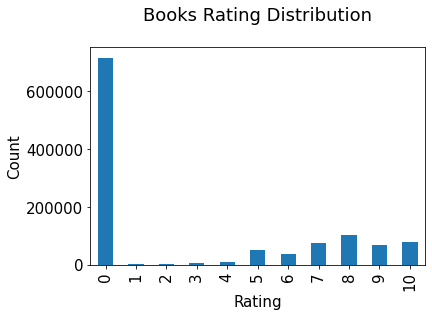

In [13]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Books Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [14]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


In [15]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


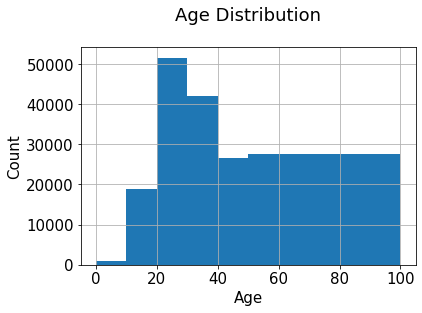

In [17]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [18]:
# Users with less than 200 ratings, and books with less than 100 ratings are excluded.
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]

counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

In [20]:
# k-Nearest Neighbors (kNN)
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
print(combine_book_rating.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                          Book-Title  
0  Politically Correct Bedtime Stories: Modern Ta...  
1  Politically Correct Bedtime Stories: Modern Ta...  
2  Politically Correct Bedtime Stories: Modern Ta...  
3  Politically Correct Bedtime Stories: Modern Ta...  
4  Politically Correct Bedtime Stories: Modern Ta...  


In [25]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['Book-Title'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['Book-Title'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['Book-Title', 'totalRatingCount']]
    )
print(book_ratingCount.head())

                                          Book-Title  totalRatingCount
0   A Light in the Storm: The Civil War Diary of ...                 2
1                              Always Have Popsicles                 1
2               Apple Magic (The Collector's series)                 1
3   Beyond IBM: Leadership Marketing and Finance ...                 1
4   Clifford Visita El Hospital (Clifford El Gran...                 1


In [27]:
# Combine the rating data with the total rating count data
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
print(rating_with_totalRatingCount.head())

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                          Book-Title  totalRatingCount  
0  Politically Correct Bedtime Stories: Modern Ta...                82  
1  Politically Correct Bedtime Stories: Modern Ta...                82  
2  Politically Correct Bedtime Stories: Modern Ta...                82  
3  Politically Correct Bedtime Stories: Modern Ta...                82  
4  Politically Correct Bedtime Stories: Modern Ta...                82  
count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [28]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [29]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
print(rating_popular_book.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                          Book-Title  totalRatingCount  
0  Politically Correct Bedtime Stories: Modern Ta...                82  
1  Politically Correct Bedtime Stories: Modern Ta...                82  
2  Politically Correct Bedtime Stories: Modern Ta...                82  
3  Politically Correct Bedtime Stories: Modern Ta...                82  
4  Politically Correct Bedtime Stories: Modern Ta...                82  


In [30]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
print(us_canada_user_rating.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
3   12538  002542730X          10   
4   13552  002542730X           0   
5   16795  002542730X           0   

                                          Book-Title  totalRatingCount  \
0  Politically Correct Bedtime Stories: Modern Ta...                82   
1  Politically Correct Bedtime Stories: Modern Ta...                82   
3  Politically Correct Bedtime Stories: Modern Ta...                82   
4  Politically Correct Bedtime Stories: Modern Ta...                82   
5  Politically Correct Bedtime Stories: Modern Ta...                82   

                        Location  
0          gilbert, arizona, usa  
1      knoxville, tennessee, usa  
3          byron, minnesota, usa  
4        cordova, tennessee, usa  
5  mechanicsville, maryland, usa  


In [38]:
# Convert table into matrix filling up null values with zero
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'Book-Title'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'Book-Title', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)
print(model_knn)

NearestNeighbors(algorithm='brute', metric='cosine')


In [39]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
print(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1))
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
us_canada_user_rating_pivot.index[query_index]

656
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.
   0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.
   0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.
   0.  0.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0. 

'The Summons'

In [40]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Summons:

1: The Empty Chair, with distance of 0.6996798612258572:
2: The Street Lawyer, with distance of 0.727222952010289:
3: Executive Orders (Jack Ryan Novels), with distance of 0.7339703767139001:
4: 1st to Die: A Novel, with distance of 0.7414092399777072:
5: Roses Are Red (Alex Cross Novels), with distance of 0.7548106969592265:
